# 프로젝트: 주식 예측해보기
## 🎯 평가기준
1. 시계열의 stationary 확인
2. ARIMA 모델 모수 선택 근거 제시
3. 3개 이상 종목의 예측 모델 오차율이 기준 이하(MAPE 15% 미만)로 예측

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6

ADF Test로 시계열 데이터의 stationary를 테스트하는 함수

In [28]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    
    print('Results of Dickey-Fuller Test: ')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [32]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

# Samsung 예측 

## 1. 데이터 로드

In [50]:
stockpath = os.getenv('HOME')+'/aiffel/stock_prediction/005930.KS.csv'
ts = pd.read_csv(stockpath, index_col='Date', usecols=['Close','Date'],parse_dates=True)

ts = ts['Close']
ts.head()

Date
2020-09-07    56500.0
2020-09-08    58700.0
2020-09-09    58400.0
2020-09-10    59200.0
2020-09-11    59000.0
Name: Close, dtype: float64

## 2. 전처리
### 결측치 처리

0


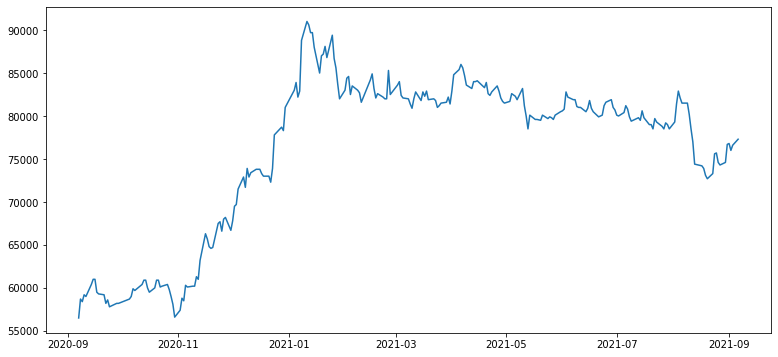

In [64]:
ts=ts.interpolate(method='time')
print(ts.isna().sum())
plt.plot(ts)

In [65]:
adf_test(ts)

Results of Dickey-Fuller Test: 
Test Statistic                  -2.149826
p-value                          0.224957
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


### 로그 변환

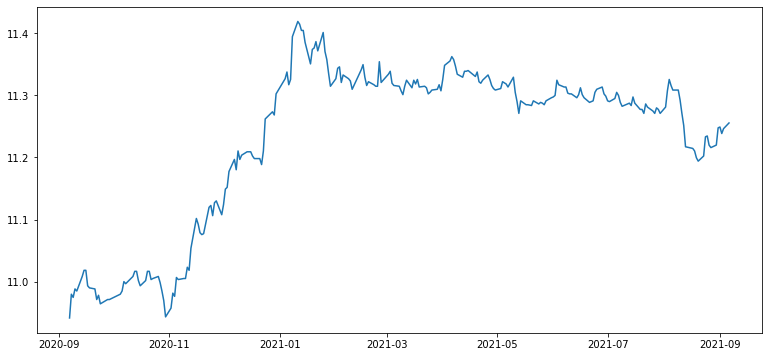

In [66]:
ts_log = np.log(ts)
plt.plot(ts_log)

In [67]:
adf_test(ts_log)

Results of Dickey-Fuller Test: 
Test Statistic                  -2.306020
p-value                          0.170034
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


로그변환을 하니 0.22->0.17로 p-value가 줄어들었다. 따라서 로그변환을 한 것이 더 안정적이라고 해석할 수 있다.

### Moving average 제거 - Trend 상쇄하기

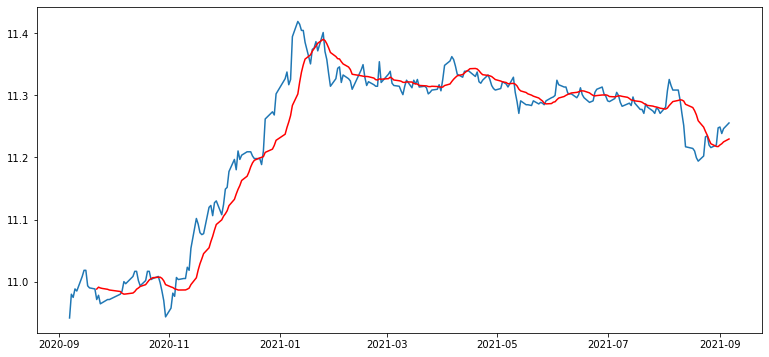

In [68]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

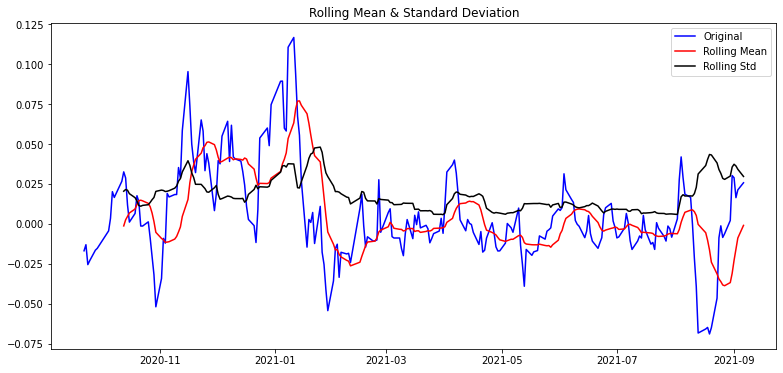

In [69]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.dropna(inplace=True)
plot_rolling_statistics(ts_log_moving_avg)

In [70]:
adf_test(ts_log_moving_avg)

Results of Dickey-Fuller Test: 
Test Statistic                  -2.888375
p-value                          0.046717
#Lags Used                      11.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


trend 상쇄를 한 결과 0.17->0.04로 2배 가까이 p-value가 줄어들었다.

### 차분(Differencing) - 계절성 상쇄하기

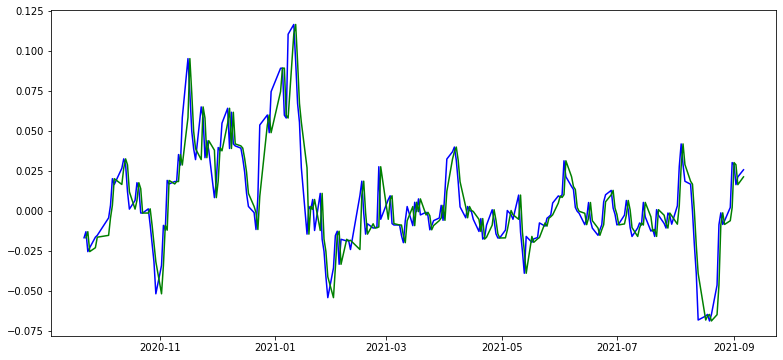

In [71]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

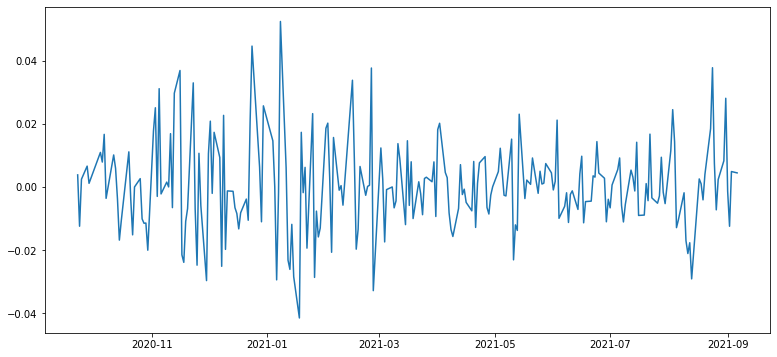

In [72]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

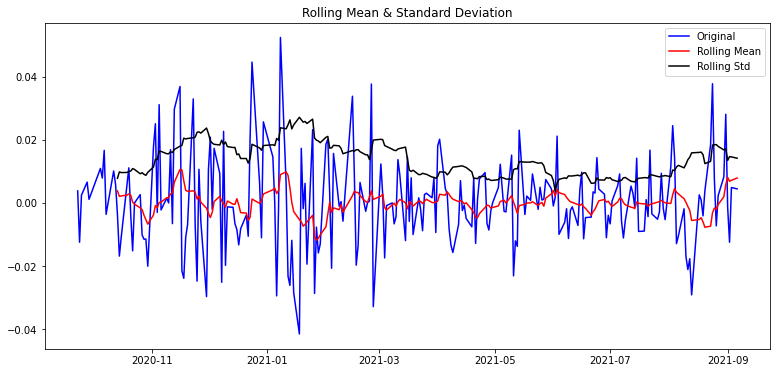

In [73]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [74]:
adf_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test: 
Test Statistic                -6.861979e+00
p-value                        1.593920e-09
#Lags Used                     1.200000e+01
Number of Observations Used    2.230000e+02
Critical Value (1%)           -3.460019e+00
Critical Value (5%)           -2.874590e+00
Critical Value (10%)          -2.573725e+00
dtype: float64


0.04->1.593920e-09로 p-value가 더 줄어든 것을 볼 수 있다.

### 시계열 분해

In [75]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

In [81]:
ts_log.index.min(), ts_log.index.max()

(Timestamp('2020-09-07 00:00:00'), Timestamp('2021-09-06 00:00:00'))

# Kakao 예측 

## 1. 데이터 로드

In [16]:
stockpath = os.getenv('HOME')+'/aiffel/stock_prediction/035720.KS.csv'
ts = pd.read_csv(stockpath, index_col='Date', usecols=['Close','Date'],parse_dates=True)

ts.head()

,Close
Date,
2020-09-07,78400.0
2020-09-08,78000.0
2020-09-09,76800.0
2020-09-10,77100.0
2020-09-11,75800.0


## 2. 전처리

Close    0
dtype: int64


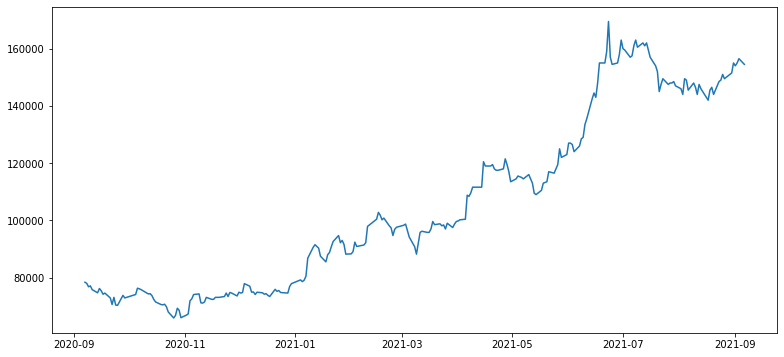

In [17]:
ts=ts.interpolate()
print(ts.isna().sum())
plt.plot(ts)

# Hyundai Mobis 예측

## 1. 데이터 로드

In [19]:
stockpath = os.getenv('HOME')+'/aiffel/stock_prediction/012330.KS.csv'
ts = pd.read_csv(stockpath, index_col='Date', usecols=['Close','Date'],parse_dates=True)

ts.head()

,Close
Date,
2020-09-07,225500.0
2020-09-08,225500.0
2020-09-09,223500.0
2020-09-10,224000.0
2020-09-11,226000.0


## 2. 전처리

Close    0
dtype: int64


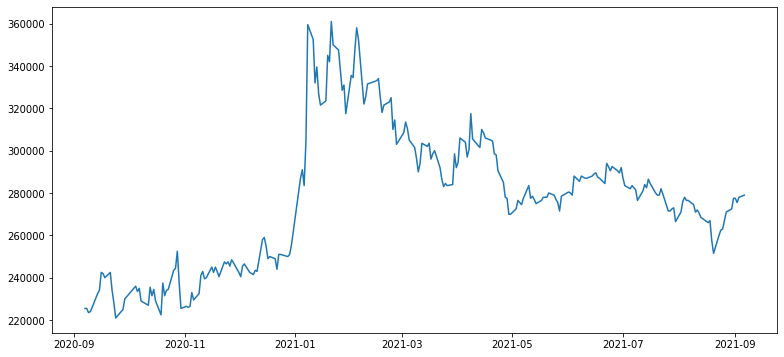

In [20]:
ts=ts.interpolate()
print(ts.isna().sum())
plt.plot(ts)